In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install bert

In [ ]:
# !pip install transformers

In [1]:
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModel, BertTokenizerFast
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
from transformers import AutoTokenizer, BertModel
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
df = pd.read_csv ('/content/drive/MyDrive/XAI_ADR/FinalADR.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df=df.dropna()
df.head()

,text,searchTerm,disease,processed_text
0,Buy top levothyroxine online on our free compa...,Levothyroxine,Cancer,"['buy', 'top', 'free', 'comparison', 'site', '..."
1,@femmebostonian @Cherrell_Brown This has been ...,Levothyroxine,Cancer,"['super', 'help', 'switch', 'due', 'cost', 'ne..."
2,For a decade I was on Levothyroxine 137 mcg. I...,Levothyroxine,Cancer,"['decad', 'see', 'even', 'bit', 'bad', 'heart'..."
3,@yourAAH Hi could you tell me which of your UK...,Levothyroxine,Cancer,"['hi', 'could', 'tell', 'stock']"
4,And my levothyroxine,Levothyroxine,Cancer,[]


In [4]:
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
import nltk
import re
import string
import pandas as pd
import numpy as np
from wordcloud import WordCloud
string.punctuation

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))
english_words = set(words.words())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess(text):


    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = word_tokenize(text)

    return ' '.join(tokens)



df['Cleantext'] = df['text'].apply(preprocess)

In [6]:
X=df.Cleantext
Y=df.disease

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, Y, test_size=0.15, stratify=Y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, stratify=y_train_val, random_state=42
)

print(f'X_train: {len(X_train)}\nX_val: {len(X_val)}\nX_test: {len(X_test)}')


X_train: 2755
X_val: 591
X_test: 591


In [7]:
import pandas as pd

summary = pd.DataFrame({
    "Train": y_train.value_counts(),
    "Validation": y_val.value_counts(),
    "Test": y_test.value_counts()
})
print(summary)


          Train  Validation  Test
disease                          
Diabetes   1263         271   271
Cancer      848         182   182
High_Bp     644         138   138


### Create a dataset for shap

In [ ]:
!pip install datasets

In [8]:
from datasets import Dataset

data_dict = {
    'text': X_test.tolist(),
    'label': y_test.tolist()
}

test_data = Dataset.from_dict(data_dict)



In [9]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)


In [10]:
X_train = X_train.tolist()
y_train = y_train.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()
y_val=y_val.tolist()
X_val=X_val.tolist()


In [11]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=649)
valid_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=649)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=649)


In [12]:
class DATALOADER(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = DATALOADER(train_encodings, y_train)
valid_dataset = DATALOADER(valid_encodings, y_val)
test_dataset = DATALOADER(test_encodings, y_test)

In [13]:
from transformers import AutoModelForSequenceClassification,AutoConfig

id2label = {0: 'Cancer', 1: 'Diabetes', 2: 'High_Bp'}
label2id = {label: idx for idx, label in id2label.items()}
config = AutoConfig.from_pretrained("roberta-base")

# Load and update the configuration
config.id2label = id2label
config.label2id = label2id
config.num_labels = len(id2label)
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", config=config)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
import numpy as np
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

def compute_metrics(pred):
    labels = pred.label_ids
    logits = pred.predictions

    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    mcc = matthews_corrcoef(labels, preds)

    classes = np.unique(labels)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "matthews_corrcoef": mcc,
    }


In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./bert',
    num_train_epochs=10,
    fp16=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=20,
    gradient_accumulation_steps=2,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    logging_steps=400,
    save_steps=400,
    eval_strategy="steps",
    learning_rate=3e-5,
    report_to=None
)


In [16]:
from transformers import  Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [17]:
import os
os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_API_KEY"] = ""


In [18]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Matthews Corrcoef
400,0.317500,0.101111,0.974619,0.974800,0.974619,0.974512,0.960406


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Matthews Corrcoef
400,0.317500,0.101111,0.974619,0.974800,0.974619,0.974512,0.960406
800,0.050800,0.128401,0.978003,0.978424,0.978003,0.977978,0.966078
1200,0.030800,0.113678,0.981387,0.981652,0.981387,0.981408,0.971153
1600,0.022200,0.111280,0.979695,0.980141,0.979695,0.979706,0.968663


TrainOutput(global_step=1730, training_loss=0.09872818447950947, metrics={'train_runtime': 565.8939, 'train_samples_per_second': 48.684, 'train_steps_per_second': 3.057, 'total_flos': 1288356433427700.0, 'train_loss': 0.09872818447950947, 'epoch': 10.0})

In [19]:
import time
import psutil
sample_texts = X_test[:50]  # adjust size as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Tokenize inputs
sample_inputs = tokenizer(sample_texts, return_tensors='pt', padding=True, truncation=True)
sample_inputs = {k: v.to(device) for k, v in sample_inputs.items()}

# --- Count trainable parameters ---
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# --- Measure inference time per sample ---
def measure_inference_time(model, inputs, repetitions=5):
    model.eval()
    torch.cuda.empty_cache()
    times = []

    with torch.no_grad():
        for _ in range(repetitions):
            torch.cuda.synchronize()
            start = time.time()
            _ = model(**inputs)
            torch.cuda.synchronize()
            end = time.time()
            times.append(end - start)

    avg_time = sum(times) / repetitions
    return avg_time / inputs['input_ids'].size(0)  # time per sample

# --- Measure RAM and GPU memory ---
def measure_memory():
    ram = psutil.Process().memory_info().rss / 1024 ** 2  # in MB
    gpu_allocated = torch.cuda.memory_allocated() / 1024 ** 2
    gpu_reserved = torch.cuda.memory_reserved() / 1024 ** 2
    return ram, gpu_allocated, gpu_reserved

# --- Run Benchmark ---
trainable_params = count_trainable_parameters(model)
inference_time = measure_inference_time(model, sample_inputs)
ram, gpu_allocated, gpu_reserved = measure_memory()

model_results = {
    "model_name": "roberta",
    "trainable_params": trainable_params,
    "inference_time_per_sample (sec)": round(inference_time, 4),
    "ram_usage_MB": round(ram, 2),
    "gpu_allocated_MB": round(gpu_allocated, 2),
    "gpu_reserved_MB": round(gpu_reserved, 2)
}

print(model_results)

{'model_name': 'roberta', 'trainable_params': 124647939, 'inference_time_per_sample (sec)': 0.0012, 'ram_usage_MB': 2064.74, 'gpu_allocated_MB': 1446.56, 'gpu_reserved_MB': 1794.0}


# ROC Plot

In [20]:
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
true_labels = predictions.label_ids


In [21]:
import torch
import torch.nn.functional as F

# Convert logits to probabilities
probabilities = F.softmax(torch.tensor(logits), dim=-2).numpy()


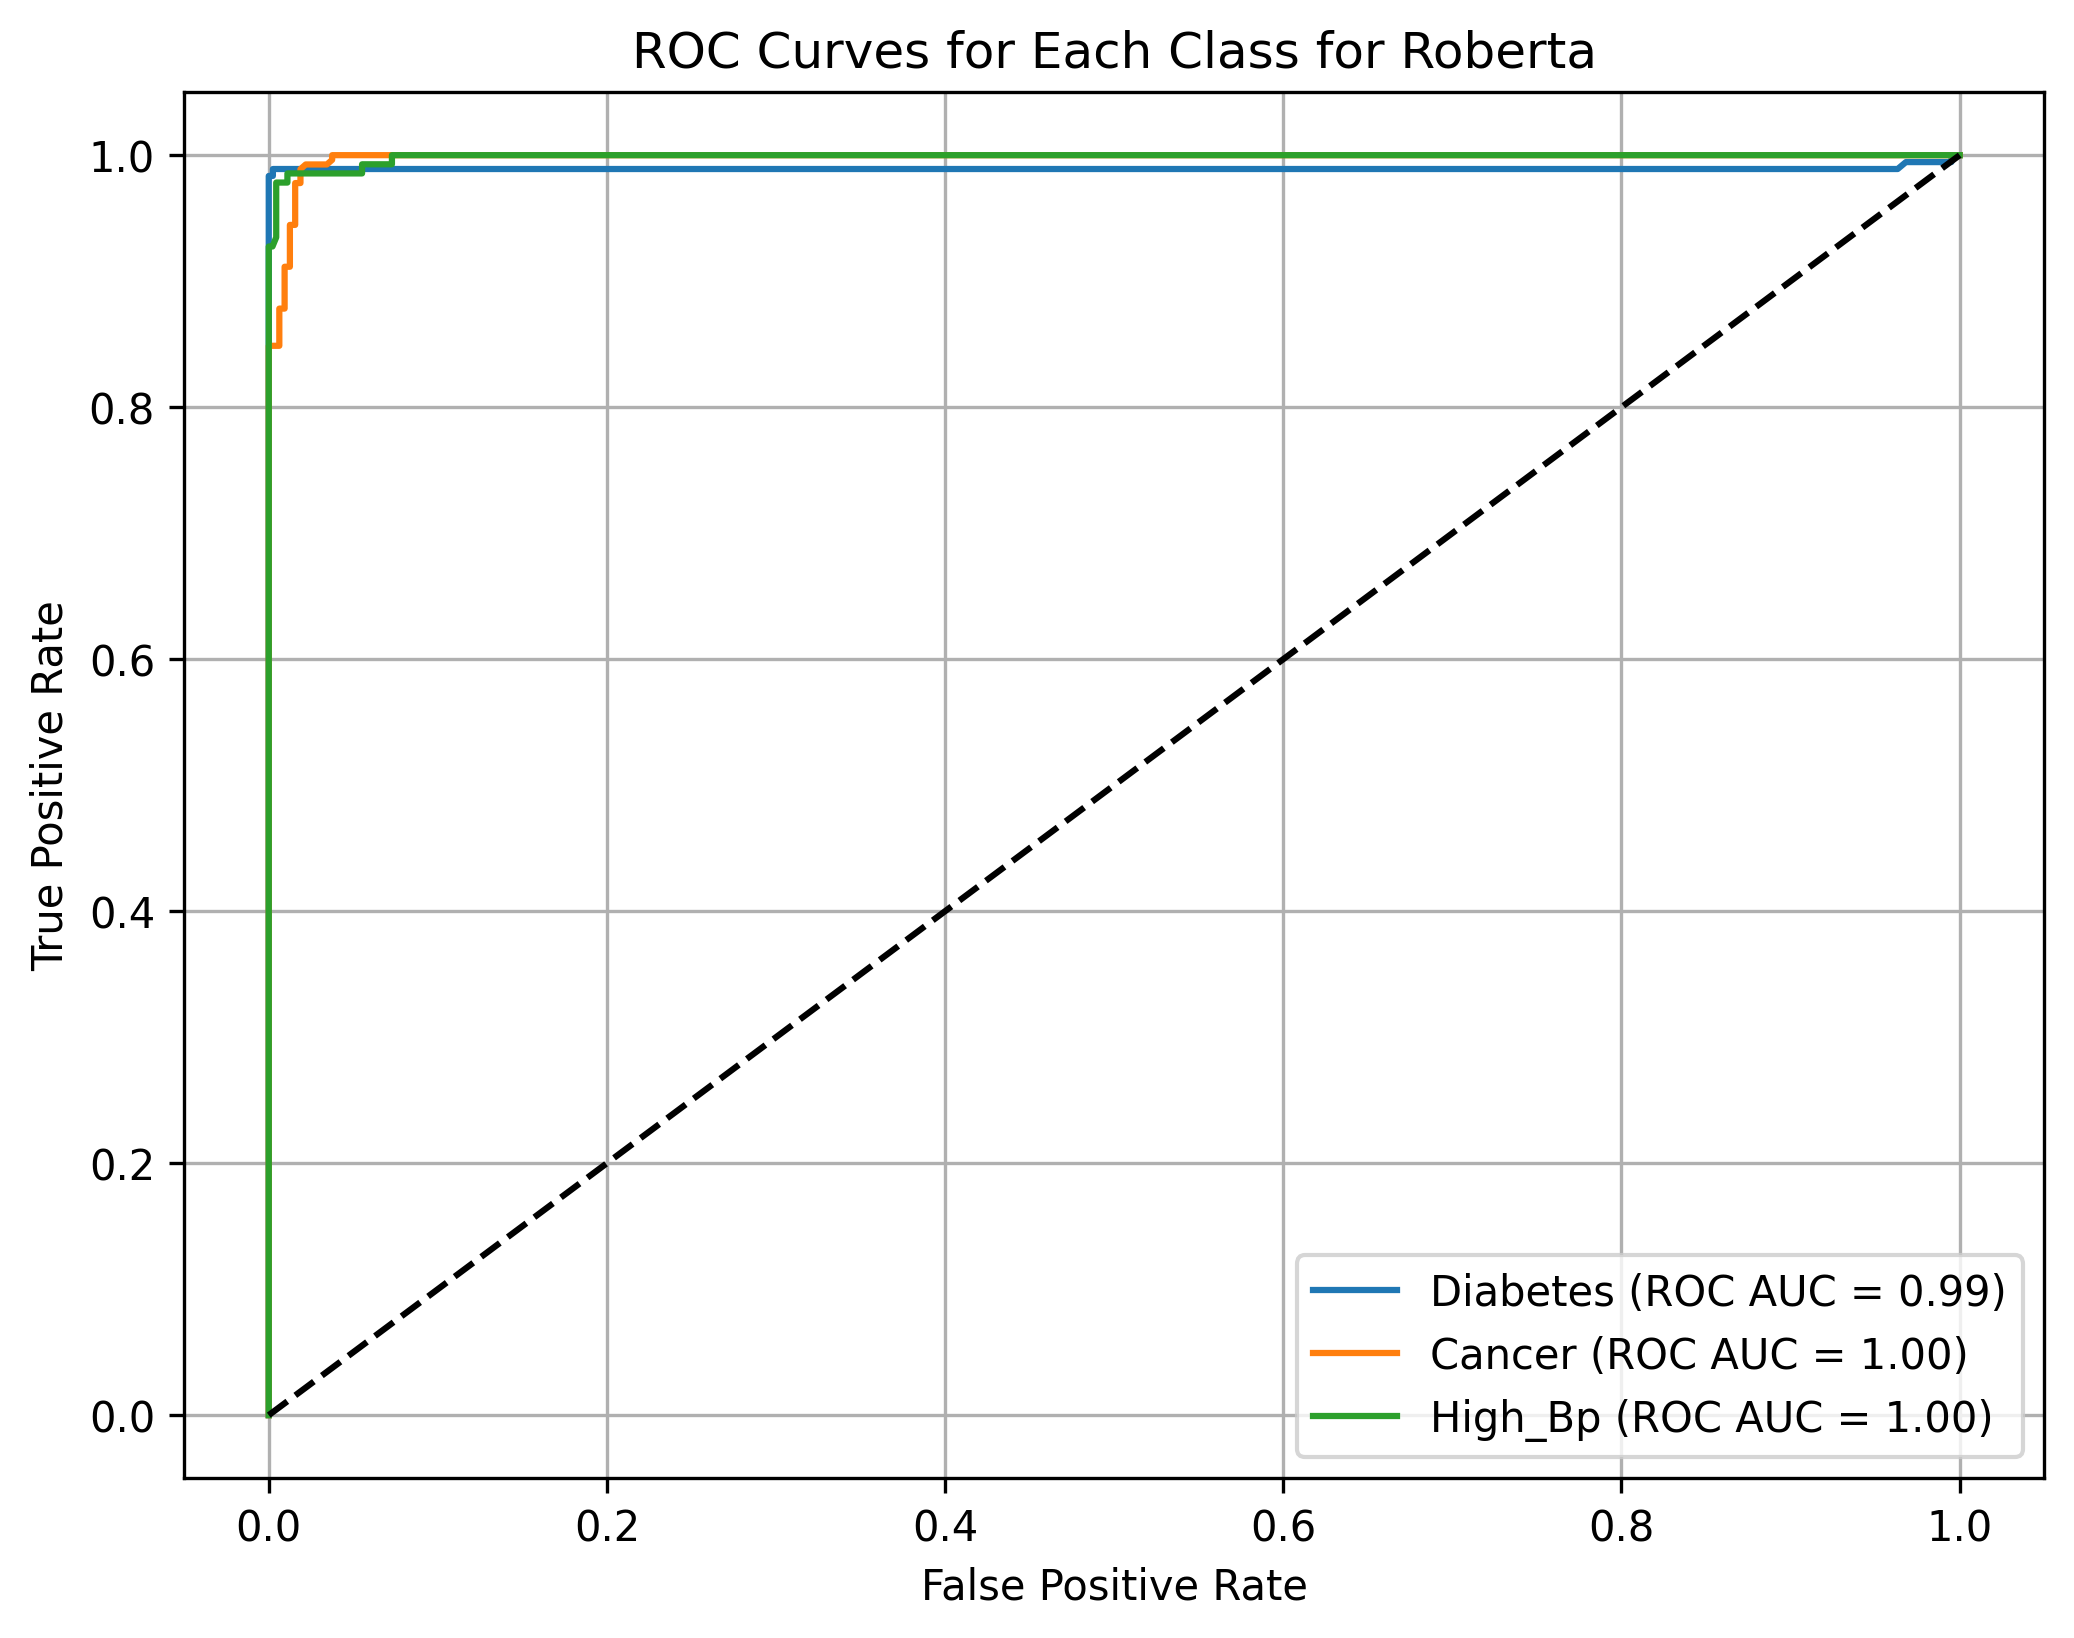

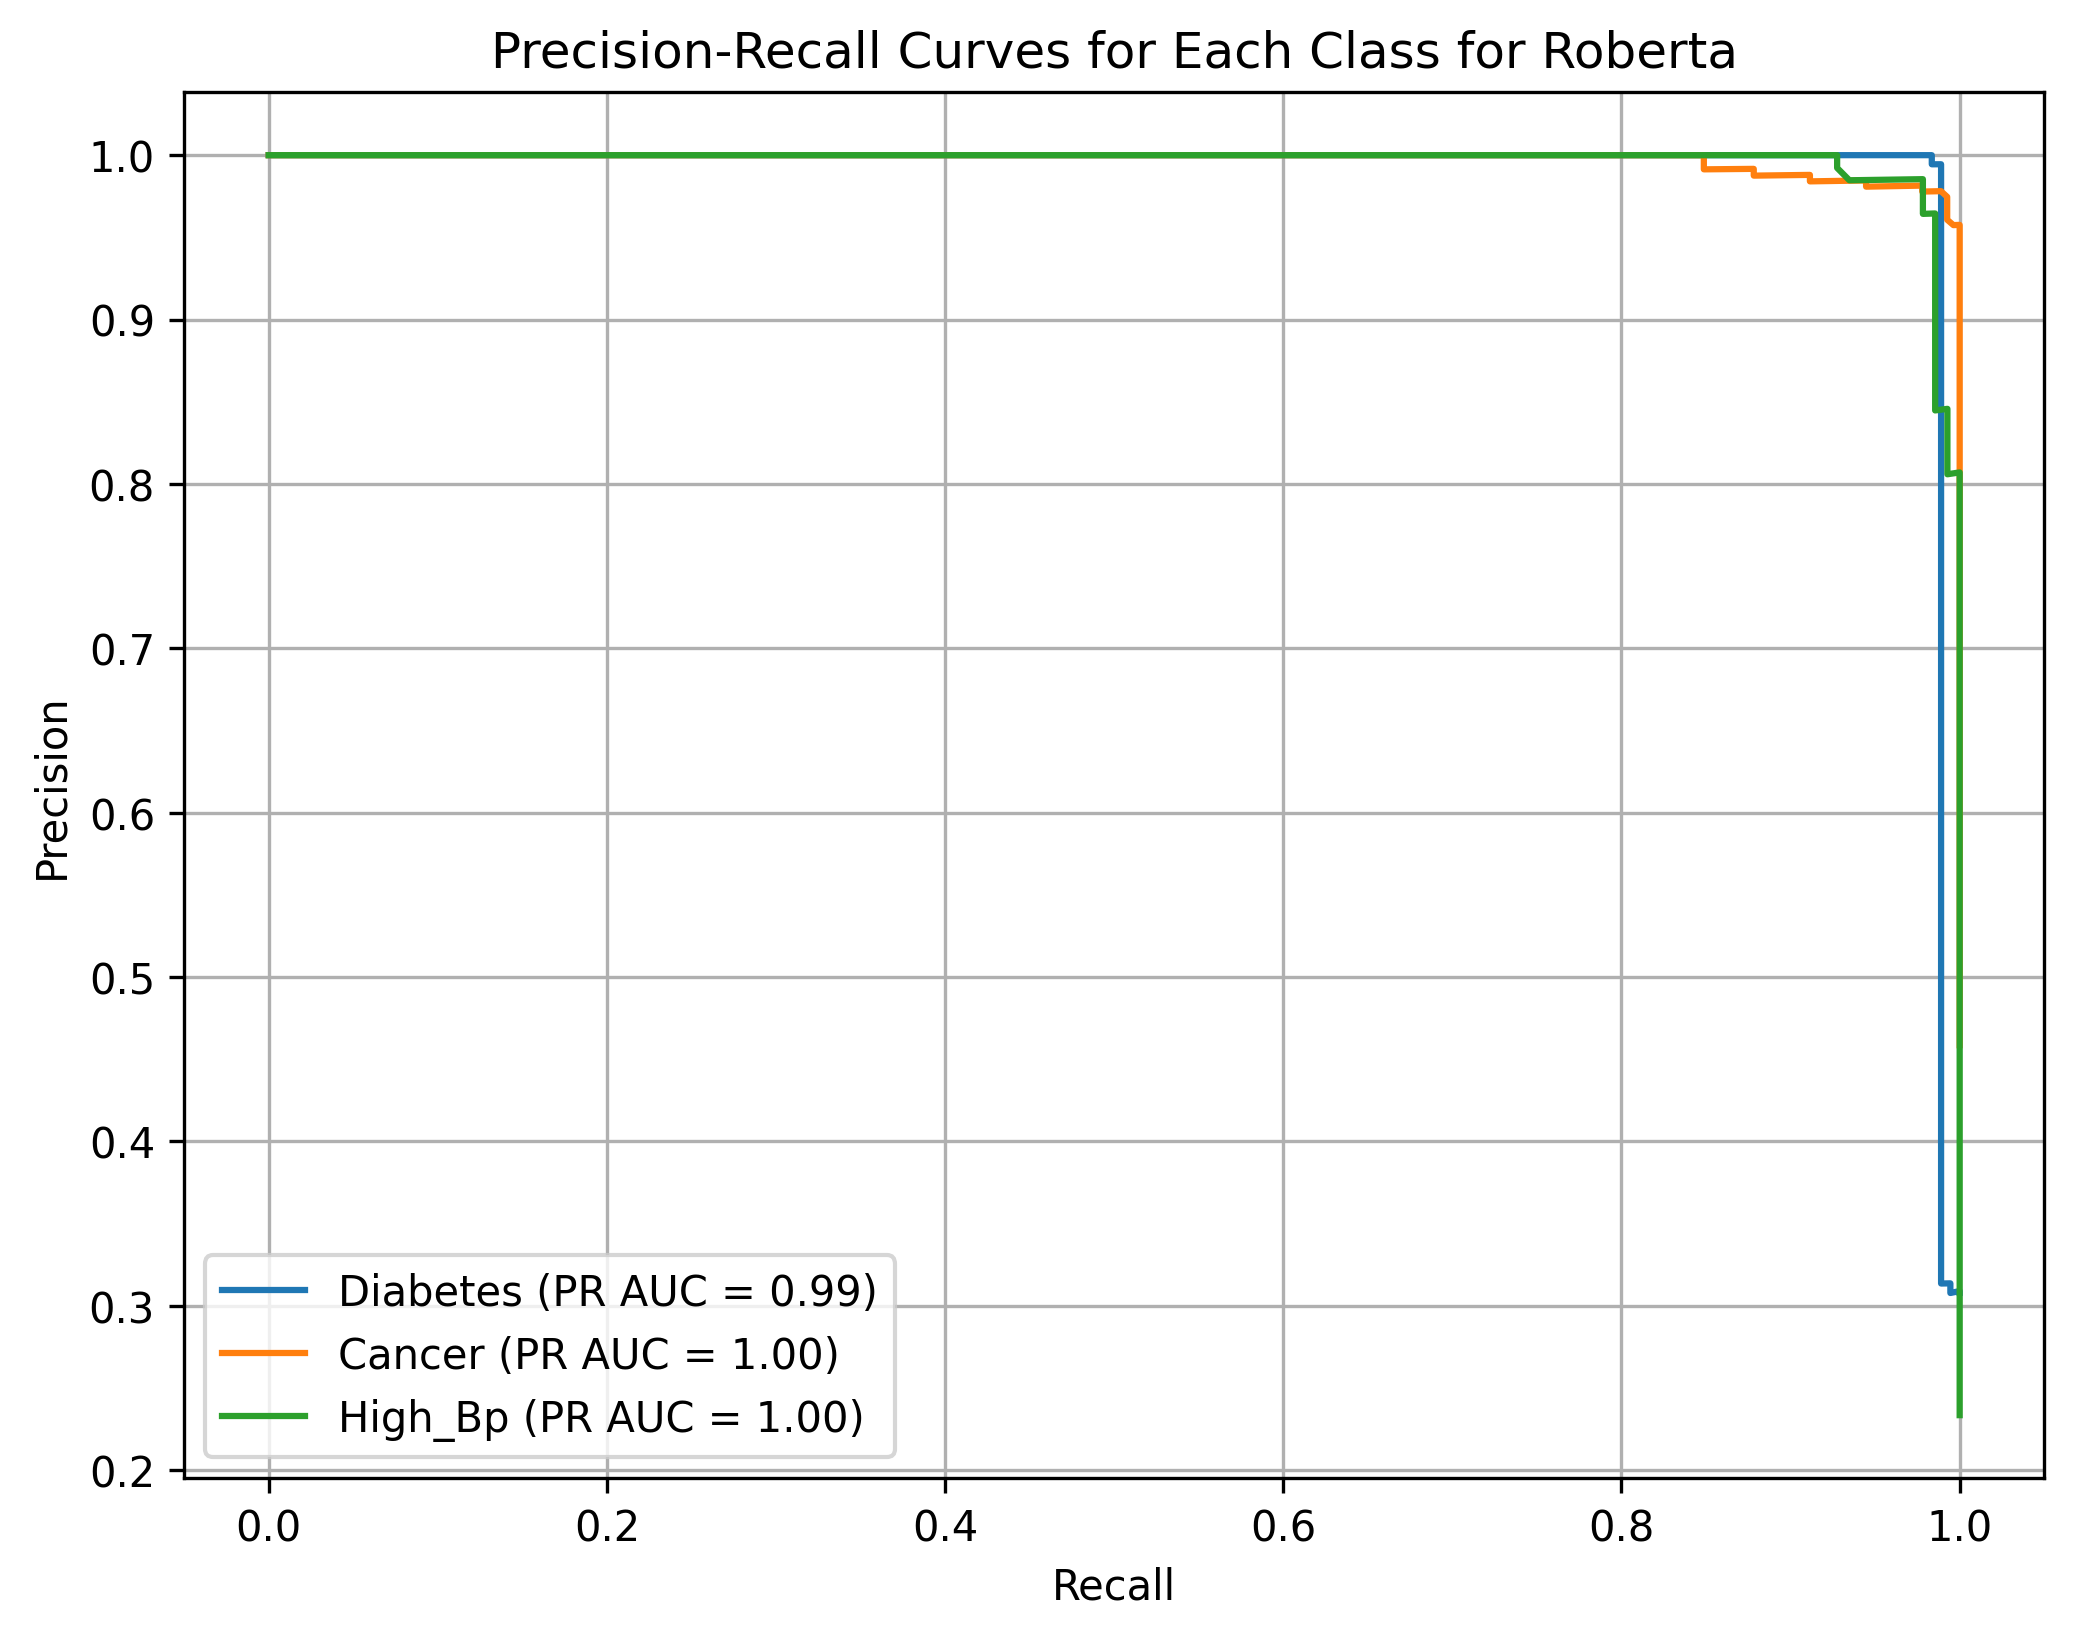

In [22]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

class_names = ['Diabetes', 'Cancer', 'High_Bp']
num_classes = len(class_names)

true_labels_binarized = label_binarize(true_labels, classes=list(range(num_classes)))

fpr, tpr, roc_auc = {}, {}, {}
precision, recall, pr_auc = {}, {}, {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(true_labels_binarized[:, i], probabilities[:, i])
    pr_auc[i] = average_precision_score(true_labels_binarized[:, i], probabilities[:, i])

plt.figure(figsize=(8, 6),dpi=300)
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (ROC AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class for Roberta')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6),dpi=300)
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} (PR AUC = {pr_auc[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class for Roberta')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [23]:
for i in range(num_classes):
    print(f'Class {i} AUC: {roc_auc[i]:.2f}')


Class 0 AUC: 0.99
Class 1 AUC: 1.00
Class 2 AUC: 1.00


## Saved model

In [24]:
# saving the fine tuned model & tokenizer
model_path = "/content/drive/MyDrive/ADRSHAPPublished/FinalRoberta"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/ADRSHAPPublished/FinalRoberta/tokenizer_config.json',
 '/content/drive/MyDrive/ADRSHAPPublished/FinalRoberta/special_tokens_map.json',
 '/content/drive/MyDrive/ADRSHAPPublished/FinalRoberta/vocab.json',
 '/content/drive/MyDrive/ADRSHAPPublished/FinalRoberta/merges.txt',
 '/content/drive/MyDrive/ADRSHAPPublished/FinalRoberta/added_tokens.json',
 '/content/drive/MyDrive/ADRSHAPPublished/FinalRoberta/tokenizer.json')

## Evaluated model

In [25]:
eval_results =trainer.evaluate(test_dataset)

# Predict on the evaluation dataset to get logits
predictions = trainer.predict(test_dataset)

In [26]:
trainer.evaluate()

{'eval_loss': 0.10111051052808762,
 'eval_accuracy': 0.9746192893401016,
 'eval_precision': 0.9748001656293306,
 'eval_recall': 0.9746192893401016,
 'eval_f1': 0.9745116109033034,
 'eval_matthews_corrcoef': 0.9604062790181909,
 'eval_runtime': 3.1133,
 'eval_samples_per_second': 189.832,
 'eval_steps_per_second': 9.636,
 'epoch': 10.0}

In [27]:
eval_results

{'eval_loss': 0.0891626700758934,
 'eval_accuracy': 0.9695431472081218,
 'eval_precision': 0.9712222692235383,
 'eval_recall': 0.9695431472081218,
 'eval_f1': 0.969232509492591,
 'eval_matthews_corrcoef': 0.9531447344842974,
 'eval_runtime': 4.3751,
 'eval_samples_per_second': 135.082,
 'eval_steps_per_second': 6.857,
 'epoch': 10.0}

In [28]:
import numpy as np

true_labels = predictions.label_ids

preds = np.argmax(predictions.predictions, axis=1)


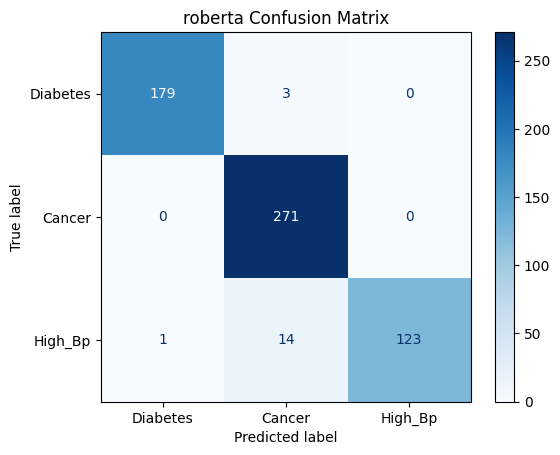

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = ['Diabetes', 'Cancer', 'High_Bp']

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.title('roberta Confusion Matrix')
plt.show()


In [30]:
report = classification_report(true_labels, preds,target_names=labels, output_dict=True)

# Print with 4 decimal places
for label, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"\nClass: {label}")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")
    else:
        print(f"{label}: {metrics:.4f}")


Class: Diabetes
  precision: 0.9944
  recall: 0.9835
  f1-score: 0.9890
  support: 182.0000

Class: Cancer
  precision: 0.9410
  recall: 1.0000
  f1-score: 0.9696
  support: 271.0000

Class: High_Bp
  precision: 1.0000
  recall: 0.8913
  f1-score: 0.9425
  support: 138.0000
accuracy: 0.9695

Class: macro avg
  precision: 0.9785
  recall: 0.9583
  f1-score: 0.9670
  support: 591.0000

Class: weighted avg
  precision: 0.9712
  recall: 0.9695
  f1-score: 0.9692
  support: 591.0000


In [31]:
import shap
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Define the path to your fine-tuned model and tokenizer
model_path = "/content/drive/MyDrive/ADRSHAPPublished/FinalRoberta"

# Load the fine-tuned model and tokenizer from the saved path
tokenizer = AutoTokenizer.from_pretrained(model_path)
model1 = AutoModelForSequenceClassification.from_pretrained(model_path)

pred = transformers.pipeline(
    "text-classification",
    model=model1,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=True,
)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
test_data

Dataset({
    features: ['text', 'label'],
    num_rows: 591
})

In [ ]:
data = pd.DataFrame({"text": test_data["text"], "disease": test_data["label"]})

In [ ]:
data[:3]

,text,disease
0,regulatory news us food drug administration dr...,Cancer
1,carvedilol district court case may needed prov...,High_Bp
2,rt pharmafactz antidiabetics rapidacting lispr...,Diabetes


In [ ]:
masker = shap.maskers.Text(tokenizer=r"\W+") # this will create a basic whitespace tokenizer
explainer= shap.Explainer(pred, masker)

In [ ]:
shap_values = explainer(data["text"])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
shap.plots.text(shap_values)